In [1]:
# use dfngp_env
import numpy as np
import pandas as pd
import torch
from pyproj import CRS, Transformer
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# surface mass balance (smb) for Ross

In this notebook we check the surface mass balance (smb) for Ross ice shelf.

# Dowload RACMO2.4p1

In the terminal, use the following command to download the zip folder from zenodo:  
`wget --content-disposition "https://zenodo.org/records/13773130/files/ANT27_RACMO24p1_data.zip?download=1"`

Unzip with:
`unzip ANT27_RACMO24p1_data.zip -d racmo24p1`

Data set:
[Monthly RACMO2.4p1 data for Greenland (11 km) and Antarctica (27 km) for SMB, SEB, near-surface temperature and wind speed (2006-2015)](https://zenodo.org/records/13773130)

Make sure to get **Version 2** since Version 1 is missing most months.

### Download data

In [2]:
# Replace with your own data path
path_to_folder = "/home/kim/data/racmo/racmo24p1/ANT27_RACMO24p1_data/"
# NOTE: Stands for smb glaciated
filename = "smbgl_monthlyS_ANT27_RACMO24p1_200601_201512.nc"
full_path = path_to_folder + filename

smb_r24 = xr.open_dataset(full_path)
print(smb_r24.smbgl.values.shape) # rlon: 262 rlat: 240
smb_r24

(120, 1, 240, 262)


<xarray.Dataset> Size: 32MB
Dimensions:       (time: 120, bnds: 2, rlon: 262, rlat: 240, height: 1,
                   nblock1: 40, nblock2: 400)
Coordinates:
  * time          (time) datetime64[ns] 960B 2006-01-16 ... 2015-12-16
  * rlon          (rlon) float64 2kB -32.75 -32.5 -32.25 ... 32.0 32.25 32.5
  * rlat          (rlat) float64 2kB -30.0 -29.75 -29.5 ... 29.25 29.5 29.75
    lon           (rlat, rlon) float64 503kB ...
    lat           (rlat, rlon) float64 503kB ...
  * height        (height) float64 8B 0.0
Dimensions without coordinates: bnds, nblock1, nblock2
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 2kB ...
    rotated_pole  float32 4B ...
    assigned      (time) int32 480B ...
    block1        (nblock1) int32 160B ...
    block2        (nblock2) int32 2kB ...
    date_bnds     (time, bnds) int32 960B ...
    dir           (rlat, rlon) float64 503kB ...
    dtg           (time) int32 480B ...
    hms_bnds      (time, bnds) int32 960B ...
    smbgl         (time, height, rlat, rlon) float32 30MB -0.00293 ... 0.002991
Attributes:
    CDI:           Climate Data Interface version 2.1.0 (https://mpimet.mpg.d...
    Conventions:   CF-1.4
    source:        RACMO2
    institution:   Royal Netherlands Meteorological Institute (KNMI)
    Domain:        ANT27y18
    Experiment:    RACMO24_1_sndrift_all_fix2
    CreationDate:  Fri Sep 15 16:45:57 2023
    comment:       asim2cdf: cpar=smbgl, iwmo=222, ilvt=105, ilev=0, idh=24, ...
    title:         Surface Mass Balance (glaciated)
    NCO:           netCDF Operators version 4.9.7 (Homepage = http://nco.sf.n...
    history:       Tue Sep 17 15:33:28 2024: cdo selyear,2006/2015 smbgl_mont...
    CDO:           Climate Data Operators version 2.1.0 (https://mpimet.mpg.d...

## Units

- Units: **kg / m-2 / month**
    - We want to transform this to **m ice equivalent / yr (average)** to compare it to ice thickness and ice flux.
- Time: 10 years (120 months)

## Coordinate projection

RACMO does **not** use the Antarctic Polar Stereographic (PS) projection. Hence we project it to PS coordinates.

In [3]:
# Source CRS used by RACMO2.4p1 
rotated_crs = CRS.from_proj4(smb_r24.rotated_pole.proj4_params)
# Target CRS (Antarctic Polar Stereographic)
ps_crs = CRS.from_epsg(3031)

# define transformer
rotated_to_polar = Transformer.from_crs(rotated_crs, ps_crs, always_xy = True)

# extracted source grid (rotated)
rlon = smb_r24['rlon'].values
rlat = smb_r24['rlat'].values
rlon2d, rlat2d = np.meshgrid(rlon, rlat)

# uses x, y order so (lon, lat) as INPUT and OUTPUT
x_ps, y_ps = rotated_to_polar.transform(rlon2d, rlat2d)

# assign as extra coordinates
smb_r24 = smb_r24.assign_coords({
    "x_ps": (("x", "y"), x_ps),
    "y_ps": (("x", "y"), y_ps),
})

## Plot  mean monthly smb

smb > 0: growth  
smb < 0: loss  

smb is dominated by snowfall (input). The interior has minimal snowfall and is thus considered a desert. While individual monthly values are negative, the sum or mean is positive. Sublimation and runoff are small compared to snowfall. 

Apparent mass balance **a = smb + bmb + dh/dt** (thinning).  
Basal mass balance (bmb) is understood to be very small. Thinning from ice dynmaics is capture in other dataset but can also be disregarded.

In [4]:
# Ross bounds
x_min = - 600_000
x_max = 400_000
y_min = - 1_400_000
y_max = - 400_000

# Buffer to improve interpolation
buffer = 27_000  # 27 km buffer
x_min -= buffer
x_max += buffer
y_min -= buffer
y_max += buffer

# Create a mask
# Slice does not work because of the new grid
mask = (
    (smb_r24.x_ps >= x_min) & (smb_r24.x_ps <= x_max) &
    (smb_r24.y_ps >= y_min) & (smb_r24.y_ps <= y_max)
)

valid = np.where(mask)
# i is for rlon, j is for rlat
i_min, i_max = valid[0].min(), valid[0].max()
j_min, j_max = valid[1].min(), valid[1].max()

smb_ross = smb_r24.isel(rlat = slice(i_min, i_max), rlon = slice(j_min, j_max))

# NOTE: With the low resolution of RACMO 4 x 8 blocks are selected
smb_ross

<xarray.Dataset> Size: 2MB
Dimensions:       (time: 120, bnds: 2, rlon: 44, rlat: 44, height: 1,
                   nblock1: 40, nblock2: 400, x: 240, y: 262)
Coordinates:
  * time          (time) datetime64[ns] 960B 2006-01-16 ... 2015-12-16
  * rlon          (rlon) float64 352B -5.0 -4.75 -4.5 -4.25 ... 5.25 5.5 5.75
  * rlat          (rlat) float64 352B -13.75 -13.5 -13.25 ... -3.5 -3.25 -3.0
    lon           (rlat, rlon) float64 15kB ...
    lat           (rlat, rlon) float64 15kB ...
  * height        (height) float64 8B 0.0
    x_ps          (x, y) float64 503kB -3.942e+06 -3.915e+06 ... 3.914e+06
    y_ps          (x, y) float64 503kB -2.956e+06 -2.956e+06 ... 2.925e+06
Dimensions without coordinates: bnds, nblock1, nblock2, x, y
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 2kB ...
    rotated_pole  float32 4B ...
    assigned      (time) int32 480B ...
    block1        (nblock1) int32 160B ...
    block2        (nblock2) int32 2kB ...
    date_bnds     (time, bnds) int32 960B ...
    dir           (rlat, rlon) float64 15kB ...
    dtg           (time) int32 480B ...
    hms_bnds      (time, bnds) int32 960B ...
    smbgl         (time, height, rlat, rlon) float32 929kB -0.00293 ... -0.5517
Attributes:
    CDI:           Climate Data Interface version 2.1.0 (https://mpimet.mpg.d...
    Conventions:   CF-1.4
    source:        RACMO2
    institution:   Royal Netherlands Meteorological Institute (KNMI)
    Domain:        ANT27y18
    Experiment:    RACMO24_1_sndrift_all_fix2
    CreationDate:  Fri Sep 15 16:45:57 2023
    comment:       asim2cdf: cpar=smbgl, iwmo=222, ilvt=105, ilev=0, idh=24, ...
    title:         Surface Mass Balance (glaciated)
    NCO:           netCDF Operators version 4.9.7 (Homepage = http://nco.sf.n...
    history:       Tue Sep 17 15:33:28 2024: cdo selyear,2006/2015 smbgl_mont...
    CDO:           Climate Data Operators version 2.1.0 (https://mpimet.mpg.d...

In [5]:
# Calculate the average SMB per year (10-year average)
n_years = smb_ross.time.shape[0] / 12  # 120 months, 10 years
# Sum over all months and divide by number of years
smb_ross_smb_peryear_kg_m_yr = (smb_ross.smbgl.values.sum(axis = 0) / n_years).squeeze()

ice_density = 917 # kg/m³
smb_ross_smb_peryear_m_ice_yr = smb_ross_smb_peryear_kg_m_yr / ice_density # convert to m ice equivalent per year

smb_ross_x = smb_r24.x_ps.values[i_min:i_max, j_min:j_max]
smb_ross_y = smb_r24.y_ps.values[i_min:i_max, j_min:j_max]

In [6]:
ice_density = 917  # kg/m³

smb_ross_ps = xr.Dataset(
    data_vars = {"smb_yearly": (("y", "x"), smb_ross_smb_peryear_m_ice_yr)},
    coords = {
        "x_ps": (("y", "x"), smb_ross_x),
        "y_ps": (("y", "x"), smb_ross_y)},
    attrs = {"units": "metres ice equivalent yr-1", "description": "surface mass balance (smb)"}
)

smb_ross_ps

<xarray.Dataset> Size: 39kB
Dimensions:     (y: 44, x: 44)
Coordinates:
    x_ps        (y, x) float64 15kB -7.885e+05 -7.621e+05 ... 5.586e+05
    y_ps        (y, x) float64 15kB -1.388e+06 -1.392e+06 ... -4.304e+05
Dimensions without coordinates: y, x
Data variables:
    smb_yearly  (y, x) float32 8kB 4.655e-07 4.655e-07 ... 0.02343 0.02458
Attributes:
    units:        metres ice equivalent yr-1
    description:  surface mass balance (smb)

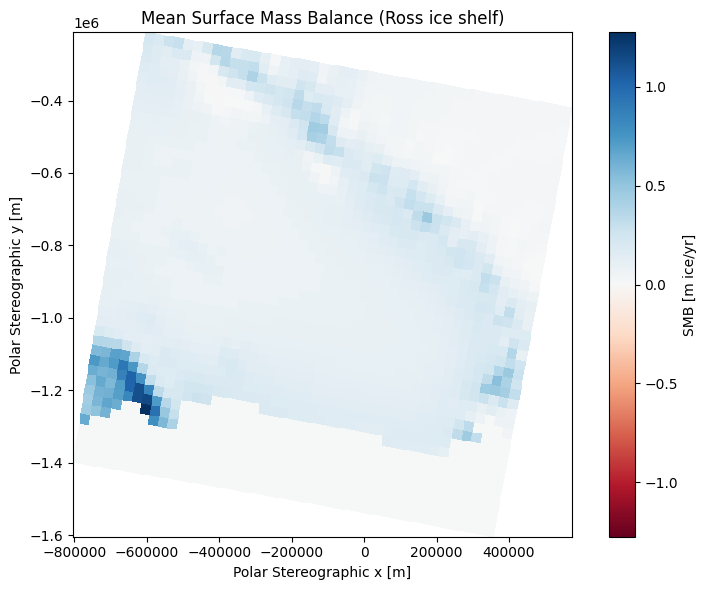

In [ ]:
# Extract the data
smb = smb_ross_ps["smb_yearly"]
x = smb_ross_ps["x_ps"]
y = smb_ross_ps["y_ps"]

# Determine symmetric color limits around zero
vmax = np.nanmax(np.abs(smb.values))
vmin = -vmax  # ensure diverging scale

# Plot
plt.figure(figsize = (8, 6))
pcm = plt.pcolormesh(
    x, y, smb,
    cmap = "RdBu",
    vmin = vmin,
    vmax = vmax,
    shading = "auto"    
)
plt.colorbar(pcm, label = "SMB [m ice/yr]")
plt.title("Mean Surface Mass Balance (Ross ice shelf)")
plt.xlabel("Polar Stereographic x [m]")
plt.ylabel("Polar Stereographic y [m]")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

# Interpolate over grid

In [8]:
# Prep smb data
data_locations_flat = np.column_stack(
    (smb_ross_ps.x_ps.values.reshape(-1), smb_ross_ps.y_ps.values.reshape(-1)))  # shape (N, 2)

data_values = smb_ross_ps.smb_yearly.values.reshape(-1)  # shape (N,)

In [10]:
# grid = torch.load("/home/kim/ice_shelves_flux_decomposition/data/bedmap_500m_grid_ross_long.pt", weights_only = False)
grid = torch.load("/home/kim/ice_shelves_flux_decomposition/data/bedmap_500m_grid_ross_long_ds.pt", weights_only = False)

grid_norm = torch.load("/home/kim/ice_shelves_flux_decomposition/data/bedmap_500m_grid_ross_norm_long_ds.pt", weights_only = False)

# 1.8 M in high-res
# 4 k in low-res
grid.shape

torch.Size([2, 4531])

In [11]:
target_locations_flat_np = np.array(grid.T)
target_locations_flat_np_norm = np.array(grid_norm.T)

/tmp/ipykernel_75202/3175614797.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  target_locations_flat_np = np.array(grid.T)
/tmp/ipykernel_75202/3175614797.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  target_locations_flat_np_norm = np.array(grid_norm.T)


In [12]:
# --- Region data ---
smb_grid_interp = griddata(data_locations_flat, data_values, target_locations_flat_np, 
                           method = "cubic")

mean_smb = np.mean(smb_grid_interp).item()

print(
    f"The mean of the interpolated SMB in the Ross region is: "
    f"{mean_smb:.4f} metre ice/yr ({mean_smb * 100:.1f} cm/yr)."
)

The mean of the interpolated SMB in the Ross region is: 0.1229 metre ice/yr (12.3 cm/yr).


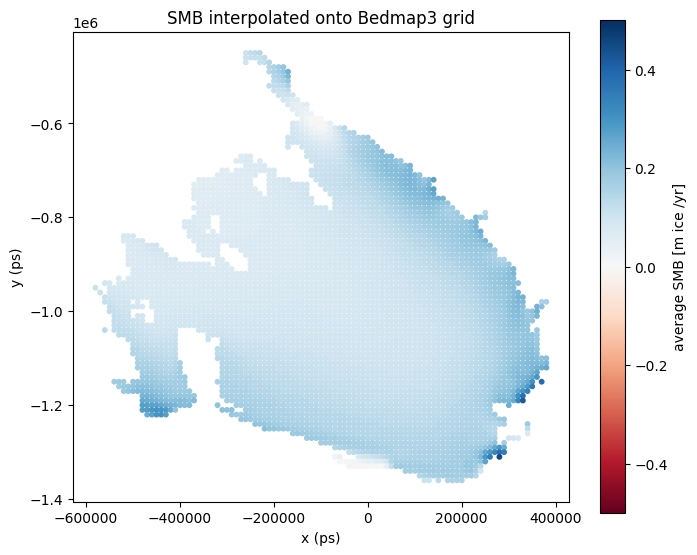

In [17]:
plt.figure(figsize = (8, 8))

plt.scatter(
    target_locations_flat_np[:, 0], 
    target_locations_flat_np[:, 1],
    c = smb_grid_interp, 
    cmap = "RdBu", 
    vmin = -0.5, vmax = 0.5,
    s = 10)

plt.colorbar(label = "average SMB [m ice /yr]", shrink = 0.8)
plt.xlabel("x (ps)")
plt.ylabel("y (ps)")
plt.title("SMB interpolated onto Bedmap3 grid")
plt.gca().set_aspect("equal")
plt.show()

In [18]:
# NOTE: Use norm
tensor_x_y_smb_m_yr = torch.cat((
    torch.tensor(target_locations_flat_np_norm),
    torch.tensor(smb_grid_interp).unsqueeze(-1),
    ), dim = -1)

In [19]:
torch.save(tensor_x_y_smb_m_yr, "data/smb_ross_ds_norm_m_per_yr.pt")